# Affine flows in 2D Cartesian Grids

Solving 
$$ |\nabla u(x)| \kappa^{1/3}_+(x) = f(x), \quad x \in \Omega $$
where $\kappa(x)$

In [1]:
import os
import numpy as np
import time
import tqdm
import matplotlib.pyplot as plt
from MonotoneScheme import Affine2DSolver, interpolate

# make folder if not exists
save_fig_path = 'figures'
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)
save_data_path = 'data'
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

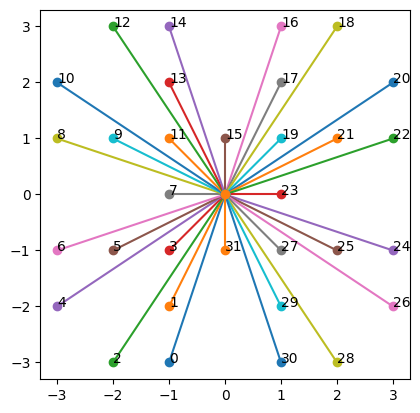

In [2]:
# 2D version
def get_stencils_2d(stencil_size=3):
    # Let's get a numpy array that contains the list of stencils given the stencil size in 3D
    stencils_tmp = []
    dim = 2

    for i1 in range(-stencil_size, stencil_size+1):
        for i2 in range(-stencil_size, stencil_size+1):
            if i1!= 0 or i2!=0:
                stencils_tmp.append((i1,i2, np.arctan2(i1,i2), i1*i1 + i2*i2))

    stencils_tmp.sort(key=lambda x: x[dim+1])
    stencils_tmp.sort(key=lambda x: x[dim])
    stencils = []
    for i, it in enumerate(stencils_tmp):
        if i == 0:
            stencils.append(it[:dim])
        else:
            if it[dim] != stencils_tmp[i-1][dim]:
                stencils.append(it[:dim])
    return stencils

stencil_size = 3
stencils = get_stencils_2d(stencil_size = stencil_size)
fig = plt.figure()
ax = fig.add_subplot(111)
for idx,i in enumerate(stencils):
    ax.plot([0,i[0]], [0,i[1]], 'o-')
    ax.text(i[0],i[1], f"{idx}")
ax.set_aspect('equal')
plt.show()

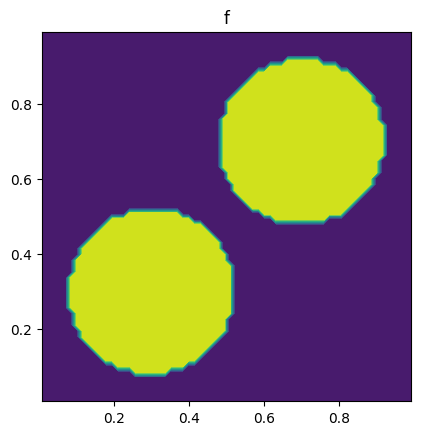

In [9]:
# create an empty f
n = 64
f = np.zeros((n,n))
u = np.ones((n,n))

# initializing f
xx = np.linspace(0.5/n,1-0.5/n,n)
X,Y = np.meshgrid(xx,xx)

def f_ellipse():
    f = np.zeros((n,n))
    theta = -np.pi/3.0
    Xr = 0.5 + np.cos(theta)*(X-0.5) - np.sin(theta)*(Y-0.5)
    Yr = 0.5 + np.sin(theta)*(X-0.5) + np.cos(theta)*(Y-0.5)
    f[4*pow(Xr - 0.5,2) + pow(Yr-0.5,2) < 0.5 ** 2] = 1
    return f

# f = f_ellipse()
# f[(np.abs(X-0.5)<0.4) & (np.abs(Y-0.5)<0.4)] = 1
# f[(np.abs(X-0.5)<0.3) & (np.abs(Y-0.5)<0.3)] = 1
f[((X-0.3)**2 + (Y-0.3)**2 <0.22**2) | ((X-0.7)**2 + (Y-0.7)**2 <0.22**2)] = 1

# plotting f
fig = plt.figure()
ax = fig.add_subplot()
ax.contourf(X,Y,f)
ax.set_title("f")
ax.set_aspect('equal')
plt.show()

Constructor finished. n:  64 stencil size:  3 number of stencils:  32


 98%|█████████▊| 49/50 [00:02<00:00, 19.19it/s]


Tolerance met! i: 50 error: 1.29e-03 time: 2.56e+00 sec


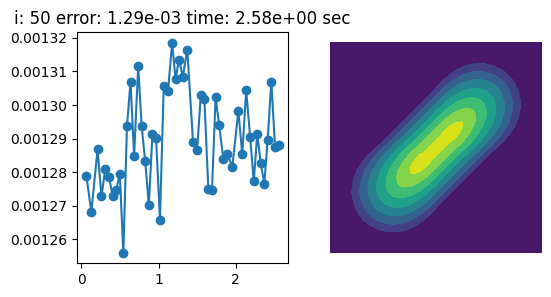

In [21]:
# optimization parameters
max_iter = 50
tolerance= 1.3e-9

# initialize the HJ solver
solver  = Affine2DSolver(f, stencils, stencil_size)

# Running the iterations
start_time = time.time()
error_array = []
time_array = []

error = 1.0
for i in tqdm.tqdm(range(1,max_iter+1)):
    error = solver.perform_one_iteration(u)
    error_array.append(error)
    time_array.append(time.time() - start_time)
    # print(f"i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec")
    # if error is less than tolerance stop the iteration
    if error < tolerance or i == max_iter:
        print(f"Tolerance met! i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec")
        break
    # save dat
    if i % 100 == 0:
        np.save(f"{save_data_path}/data-{i//100}.npy",u)
    
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(121)
ax.plot(time_array, error_array,'o-')
title_str = f"i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec"
plt.title(title_str)
ax = fig.add_subplot(122)
ax.contourf(X,Y,u)
ax.axis('off')
ax.axis('off')
ax.set_aspect('equal')
plt.savefig(f"{save_fig_path}/fig-{i//10}.png")
plt.show()